# Исследование надежности заемщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели кредитного скоринга — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

**Содержание**<a id='toc0_'></a>    
1. [Загрузка данных](#toc1_)    
2. [Предобработка данных](#toc2_)    
2.1. [Обработка пропусков](#toc2_1_)    
2.2. [Обработка аномальных значений](#toc2_2_)    
2.3. [Удаление пропусков (продолжение)](#toc2_3_)    
2.4. [Изменение типов данных](#toc2_4_)    
2.5. [Обработка дубликатов](#toc2_5_)    
2.6. [Категоризация данных](#toc2_6_)    
3. [Исследование](#toc3_)    
3.1. [Есть ли зависимость между количеством детей и возвратом кредита в срок?](#toc3_1_)    
3.2. [Есть ли зависимость между семейным положением и возвратом кредита в срок?](#toc3_2_)    
3.3. [Есть ли зависимость между уровнем дохода и возвратом кредита в срок?](#toc3_3_)    
3.4. [Как разные цели кредита влияют на его возврат в срок?](#toc3_4_)    
4. [Результаты исследования](#toc4_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=true
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 1. <a id='toc1_'></a>Загрузка данных [&#8593;](#toc0_)

In [1]:
%pip install numpy pandas matplotlib seaborn prettytable -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from prettytable import PrettyTable

In [3]:
# dataset is not presented in the repository due to copyright
data = pd.read_csv('./data/data.csv')

In [4]:
data.head(5)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


**Описание данных:**

`children` — количество детей в семье  
`days_employed` — общий трудовой стаж в днях  
`dob_years` — возраст клиента в годах  
`education` — уровень образования клиента  
`education_id` — идентификатор уровня образования  
`family_status` — семейное положение  
`family_status_id` — идентификатор семейного положения  
`gender` — пол клиента  
`income_type` — тип занятости  
`debt` — имел ли задолженность по возврату кредитов  
`total_income` — ежемесячный доход  
`purpose` — цель получения кредита  

## 2. <a id='toc2_'></a>Предобработка данных [&#8593;](#toc0_)

### 2.1. <a id='toc2_1_'></a>Обработка пропусков [&#8593;](#toc0_)

In [6]:
data.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

В двух столбцах есть пропущенные значения: `days_employed` и `total_income`.

Начнем с  `total_income`.  
На сумму дохода сильнее всего влияет тип занятости, поэтому заполним пропуски в этом столбце медианным значением по каждому типу из столбца `income_type`. Например, у человека с типом занятости `сотрудник` пропуск в столбце `total_income` будет заполнен медианным доходом среди всех записей с тем же типом.

In [7]:
for t in data['income_type'].unique():
    mask = data['income_type'] == t
    median = data.loc[mask, 'total_income'].median()
    
    data.loc[mask, 'total_income'] = data.loc[mask, 'total_income'].fillna(median)

### 2.2. <a id='toc2_2_'></a>Обработка аномальных значений [&#8593;](#toc0_)

В данных обнаружены артефакты (аномалии) — значения, которые не отражают действительность и появились по какой-то ошибке. Например, отрицательное количество дней трудового стажа в столбце `days_employed`. Заменим все отрицательные значения положительными с помощью метода `abs()`.

In [8]:
data['days_employed'] = data['days_employed'].abs()

Для каждого типа занятости выведем медианное значение трудового стажа `days_employed` в днях.

In [9]:
data.groupby('income_type')['days_employed'].median()

income_type
безработный        366413.652744
в декрете            3296.759962
госслужащий          2689.368353
компаньон            1547.382223
пенсионер          365213.306266
предприниматель       520.848083
сотрудник            1574.202821
студент               578.751554
Name: days_employed, dtype: float64

У двух типов (безработные и пенсионеры) получатся аномально большие значения. Исправить такие значения сложно, поэтому оставим их как есть.

---

In [10]:
data['children'].unique()

array([ 1,  0,  3,  2, -1,  4, 20,  5])

В столбце `children` есть два аномальных значения. Удалим строки, в которых встречаются такие аномальные значения.

In [11]:
mask = data['children'].isin([-1, 20])
data = data[~mask]

In [12]:
data['children'].unique()

array([1, 0, 3, 2, 4, 5])

### 2.3. <a id='toc2_3_'></a>Удаление пропусков (продолжение) [&#8593;](#toc0_)

Заполним пропуски в столбце `days_employed` медианными значениями по каждому типу занятости `income_type`.

In [13]:
for t in data['income_type'].unique():
    mask = data['income_type'] == t
    median = data.loc[mask, 'days_employed'].median()
    
    data.loc[mask, 'days_employed'] = data.loc[mask, 'days_employed'].fillna(median)

In [14]:
data.isna().sum()

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

### 2.4. <a id='toc2_4_'></a>Изменение типов данных [&#8593;](#toc0_)

In [15]:
data['total_income'] = data['total_income'].astype('int')

### 2.5. <a id='toc2_5_'></a>Обработка дубликатов [&#8593;](#toc0_)

Обработаем неявные дубликаты в столбце `education`. В этом столбце есть одни и те же значения, но записанные по-разному: с использованием заглавных и строчных букв. Приведем их к нижнему регистру.

In [16]:
data['education'] = data['education'].str.lower()

In [17]:
data.duplicated().sum()

71

In [18]:
data = data.drop_duplicates()

In [19]:
data.duplicated().sum()

0

### 2.6. <a id='toc2_6_'></a>Категоризация данных [&#8593;](#toc0_)

Доходы распределены неравномерно, поэтому вводить категоризацию просто по уровню доходу мы не будем. Применим методы `np.percentile()` и `pd.cut()` для создания равномерных интервалов.

In [20]:
edges = np.percentile(data['total_income'], [0, 20, 40, 60, 80, 100])
data['total_income_category'] = pd.cut(data['total_income'], bins=edges, labels=['E', 'D', 'C', 'B', 'A'], include_lowest=True)

---

In [21]:
data['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

Создадим функцию, которая на основании данных из столбца `purpose` сформирует новый столбец `purpose_category`, в который войдут следующие категории:

- `'операции с автомобилем'`,
- `'операции с недвижимостью'`,
- `'проведение свадьбы'`,
- `'получение образования'`.


In [22]:
def categorize_purpose(purpose):
    if 'жиль' in purpose or 'недвижимост' in purpose:
        return 'операции с недвижимостью'
    elif 'образовани' in purpose:
        return 'получение образования'
    elif 'свадьб' in purpose:
        return 'проведение свадьбы'
    elif 'автомобил' in purpose:
        return 'операции с автомобилем'
    
    raise ValueError(f'Cannot define category for purpose "{purpose}"')

In [23]:
data['purpose_category'] = data['purpose'].apply(categorize_purpose)

## 3. <a id='toc3_'></a>Исследование [&#8593;](#toc0_)

### 3.1. <a id='toc3_1_'></a>Есть ли зависимость между количеством детей и возвратом кредита в срок? [&#8593;](#toc0_)

Посчитаем сколько раз в таблице встречает каждое из значений количества детей.

In [24]:
data['children'].value_counts()

children
0    14091
1     4808
2     2052
3      330
4       41
5        9
Name: count, dtype: int64

Для значений `3`, `4` `5` довольно мало записей. Объединим их в одну категорию с `2`. В итоге получим следующие категории:
- `0`
- `1`
- `2+`

Напишем функцию для преобразования количества детей в категорию.

In [25]:
def get_children_category(children):
    if children == 0:
        return '0'
    elif children == 1:
        return '1'
    
    return '2+'

Применим соответствующую функцию.

In [26]:
column_name = 'children_category'

data[column_name] = data['children'].apply(get_children_category)

Проверим, что категоризация прошла успешно.

In [27]:
data['children_category'].value_counts()

children_category
0     14091
1      4808
2+     2432
Name: count, dtype: int64

Построим таблицу, отображающую количество и процентное соотношение должников в зависимости от количества детей.

In [28]:
table = PrettyTable()
table.field_names = ['Количество детей', 'Должников', 'Всего', 'Процент должников']


for children_count in sorted(data[column_name].unique()):
    mask = data[column_name] == children_count
    temp_data = data[mask]
    debts_count = temp_data['debt'].sum()
    
    table.add_row([
        children_count,
        debts_count,
        len(temp_data),
        f'{debts_count /  len(temp_data):.1%}'
    ])

print(table)

+------------------+-----------+-------+-------------------+
| Количество детей | Должников | Всего | Процент должников |
+------------------+-----------+-------+-------------------+
|        0         |    1063   | 14091 |        7.5%       |
|        1         |    444    |  4808 |        9.2%       |
|        2+        |    225    |  2432 |        9.3%       |
+------------------+-----------+-------+-------------------+


**Вывод:**

В данном случае мы видим, что среди клиентов без детей процент должников ниже примерно на `2 п.п.`. Также наблюдается разница (хоть и довольно маленькая) между клиентами с 1 ребенком и теми, у кого больше 1 ребенка. 

В итоге можно сделать вывод, что чем больше у клиента детей, тем больше вероятность невозврата платежей.

---

### 3.2. <a id='toc3_2_'></a>Есть ли зависимость между семейным положением и возвратом кредита в срок? [&#8593;](#toc0_)

Для начала изучим какие вообще семейные положения представлены.

In [29]:
data['family_status'].value_counts()

family_status
женат / замужем          12261
гражданский брак          4134
Не женат / не замужем     2796
в разводе                 1189
вдовец / вдова             951
Name: count, dtype: int64

Количество записей для категорий крайне неравномерное. Проведем категоризацию следующим образом:
- `официальный брак`
- `вне официального брака`

Создадим функцию.

In [30]:
def get_new_family_status(family_status):
    if family_status == 'женат / замужем':
        return 'официальный брак'
    
    return 'вне официального брака'

In [31]:
data['new_family_status'] = data['family_status'].apply(get_new_family_status)

In [32]:
data['new_family_status'].value_counts()

new_family_status
официальный брак          12261
вне официального брака     9070
Name: count, dtype: int64

Построим таблицу, отображающую количество и процентное соотношение должников в зависимости от семейного положения.

In [33]:
table = PrettyTable()
table.field_names = ['Семейное положение', 'Должников', 'Всего', 'Процент должников']

for children_count in sorted(data['new_family_status'].unique()):
    mask = data['new_family_status'] == children_count
    temp_data = data[mask]
    debts_count = temp_data['debt'].sum()
    
    table.add_row([
        children_count,
        debts_count,
        len(temp_data),
        f'{debts_count /  len(temp_data):.1%}'
    ])

print(table)

+------------------------+-----------+-------+-------------------+
|   Семейное положение   | Должников | Всего | Процент должников |
+------------------------+-----------+-------+-------------------+
| вне официального брака |    805    |  9070 |        8.9%       |
|    официальный брак    |    927    | 12261 |        7.6%       |
+------------------------+-----------+-------+-------------------+


**Вывод:**

В данном случае видно, что семейное положение клиента влияет на шанс невозврата кредита. Среди людей, состоящих в официальном браке на `1.3 п.п.` меньше должников по сравнению с людьми вне официального брака.

---

### 3.3. <a id='toc3_3_'></a>Есть ли зависимость между уровнем дохода и возвратом кредита в срок? [&#8593;](#toc0_)

Для начала проанализируем связь возврата кредита в срок и доход в виде категорий.

In [34]:
table = PrettyTable()
table.field_names = ['Категория дохода', 'Должников', 'Всего', 'Процент должников']

for children_count in sorted(data['total_income_category'].unique()):
    mask = data['total_income_category'] == children_count
    temp_data = data[mask]
    debts_count = temp_data['debt'].sum()
    
    table.add_row([
        children_count,
        debts_count,
        len(temp_data),
        f'{debts_count /  len(temp_data):.1%}'
    ])

print(table)

+------------------+-----------+-------+-------------------+
| Категория дохода | Должников | Всего | Процент должников |
+------------------+-----------+-------+-------------------+
|        A         |    299    |  4266 |        7.0%       |
|        B         |    358    |  4266 |        8.4%       |
|        C         |    373    |  4266 |        8.7%       |
|        D         |    358    |  4266 |        8.4%       |
|        E         |    344    |  4267 |        8.1%       |
+------------------+-----------+-------+-------------------+


Визуализируем зависимость.

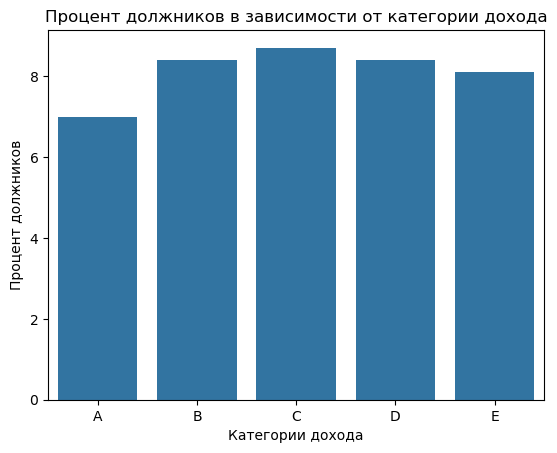

In [35]:
income_categories_info = np.array(table.rows, dtype='object')[:, -1]
income_categories_info = list(map(lambda x: float(x[:-1]), income_categories_info))

income_categories = np.array(table.rows, dtype='str')[:, 0]

ax = sns.barplot(x=income_categories, y=income_categories_info)
ax.set_xlabel('Категории дохода')
ax.set_ylabel('Процент должников')
ax.set_title('Процент должников в зависимости от категории дохода');

Теперь попробуем посмотреть распределение дохода по возврату кредита.

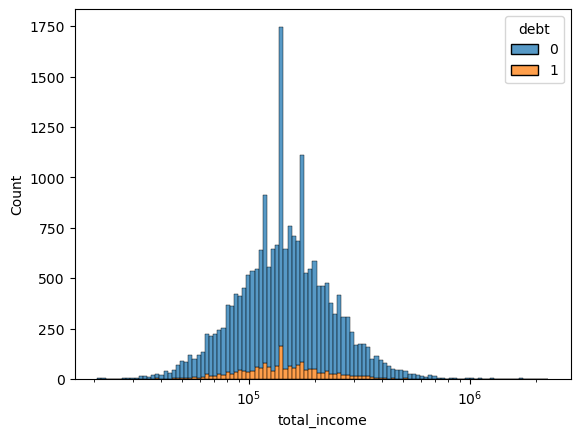

In [36]:
sns.histplot(data=data, x='total_income', hue='debt', multiple='stack', log_scale=True);

**Вывод:**

После изучения зависимости возврата кредита от дохода, можно сделать вывод, что зависимость имеет форму нормального распределения.

Самые надежные заемщики - люди с самым высоким доходом (категория `A`). Среди них процент должников составляет всего `7%`. 

А вот люди со средним доходом имеют самый высокий процент просрочек - `8.7%`

---

### 3.4. <a id='toc3_4_'></a>Как разные цели кредита влияют на его возврат в срок? [&#8593;](#toc0_)

Построим таблицу, отображающую количество и процентное соотношение должников в зависимости от цели кредита.

In [37]:
table = PrettyTable()
table.field_names = ['Цель кредита', 'Должников', 'Всего', 'Процент должников']

for children_count in sorted(data['purpose_category'].unique()):
    mask = data['purpose_category'] == children_count
    temp_data = data[mask]
    debts_count = temp_data['debt'].sum()
    
    table.add_row([
        children_count,
        debts_count,
        len(temp_data),
        f'{debts_count /  len(temp_data):.1%}'
    ])

print(table)

+--------------------------+-----------+-------+-------------------+
|       Цель кредита       | Должников | Всего | Процент должников |
+--------------------------+-----------+-------+-------------------+
|  операции с автомобилем  |    400    |  4279 |        9.3%       |
| операции с недвижимостью |    780    | 10751 |        7.3%       |
|  получение образования   |    369    |  3988 |        9.3%       |
|    проведение свадьбы    |    183    |  2313 |        7.9%       |
+--------------------------+-----------+-------+-------------------+


**Вывод:**

В данном случае можно сделать вывод, что между целью кредита и возвратом кредита в срок есть корреляция. Например, различия в процентном соотношении между категориями `операции с недвижимостью` и `операции с автомобилем` составляют `2 п.п.`.

Можно заметить, что самыми надежными заемщиками являются те, кто берут кредит на операции с недвижимостью. А вот люди, берущие кредит на автомобиль и образование - имеют самый высокий процент просрочек.

## 4. <a id='toc4_'></a>Результаты исследования [&#8593;](#toc0_)

В рамках данного проекта мы провели препроцессинг (предобработку данных):
- для количественных переменных (`total_income` и `days_employed`) заполнили пропущенные значения медианным значением по категориям;
- удалили выбросы (отрицательное количество детей и т.д.);
- изменили тип данных для столбца `days_employed` с дробного на целый;
- удалили строки, которые полностью дублируют друг друга;
- провели категоризацию данных.

---

После этого мы провели исследование зависимости факта возврата кредита в срок от различных факторов. В ходе исследования было изучено 4 различных фактора:

1. Количество детей (✅ есть зависимость)  
Самый низкий процент должников у заемщиков без детей (`7.5%` должников), а самый высокий у людей более чем с 1 ребенком (`9.3%` должников). **В общем и целом, чем больше у человека детей, тем больше шанс просрочки по кредиту.**

2. Семейное положение (✅ есть зависимость)  
В данном случае видно, что семейное положение клиента влияет на шанс невозврата кредита. Среди людей, состоящих в официально браке на `1.3 п.п.` меньше должников по сравнению с людьми, вне официального брака.

3. Доход (✅ есть зависимость)  
Самый низкий процент должников среди заемщиков с самым высоким уровнем дохода (`7%` должников) и самым низким уровнем дохода (`8.1%`). В общем и целом, зависимость процента должников от дохода имеет форму нормального распределения. Самый высокий процент должников (`8.7%`) у заемщиков со средним доходом.

4. Цель кредита (✅ есть зависимость)  
В данном случае можно сделать вывод, что между целью кредита и возвратом кредита в срок есть корреляция. Например, различия в процентном соотношении между категориями `операции с недвижимостью` и `операции с автомобилем` составляют `2 п.п.`.  
Можно заметить, что самыми надежными заемщиками являются те, кто берут кредит на операции с недвижимостью (`7.3%`). А вот люди, берущие кредит на автомобиль и образование - имеют самый высокий процент просрочек (`9.3%`)
